# Tiny Imagenet

In [ ]:
import os
# os.environ['CUDA_VISIBLE_DEVICES']='1'

In [ ]:
from miniai.imports import *
from miniai.diffusion import *

from glob import glob

In [ ]:
torch.set_printoptions(precision=4, linewidth=140, sci_mode=False)
torch.manual_seed(1)
mpl.rcParams['image.cmap'] = 'gray_r'
mpl.rcParams['figure.dpi'] = 70

set_seed(42)
if fc.defaults.cpus>8: fc.defaults.cpus=8

## Data processing

In [ ]:
path_data = Path('data')
path_data.mkdir(exist_ok=True)
path = path_data/'bedroom'

In [ ]:
url = 'https://s3.amazonaws.com/fast-ai-imageclas/bedroom.tgz'
if not path.exists():
    path_zip = fc.urlsave(url, path_data)
    shutil.unpack_archive('data/bedroom.tgz', 'data')

In [ ]:
bs = 256

In [ ]:
def to_img(f): return read_image(f, mode=ImageReadMode.RGB)/255-0.5

In [ ]:
class ImagesDS:
    def __init__(self, spec):
        self.path = Path(path)
        self.files = glob(str(spec), recursive=True)
    def __len__(self): return len(self.files)
    def __getitem__(self, i):
        im = to_img(self.files[i])
        im = im[:, :256,:256]
        im = F.avg_pool2d(im, 4)
        return (im,)

In [ ]:
tds = ImagesDS(path/'[1-9]'/f'**/*.jpg')
vds = ImagesDS(path/'0'/f'**/*.jpg')

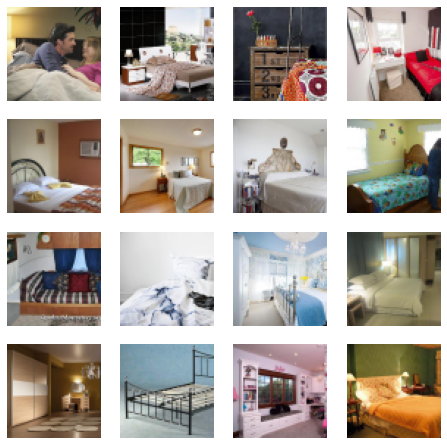

In [ ]:
dl = DataLoader(tds, batch_size=16, num_workers=fc.defaults.cpus)
(xb,) = next(iter(dl))
show_images(xb+0.5, imsize=2)

In [ ]:
def collate_ddpm(b): return noisify(default_collate(b)[0])

In [ ]:
dls = DataLoaders(*get_dls(tds, vds, bs=bs, num_workers=fc.defaults.cpus, collate_fn=collate_ddpm))

In [ ]:
(xt,t),eps = b = next(iter(dls.train))

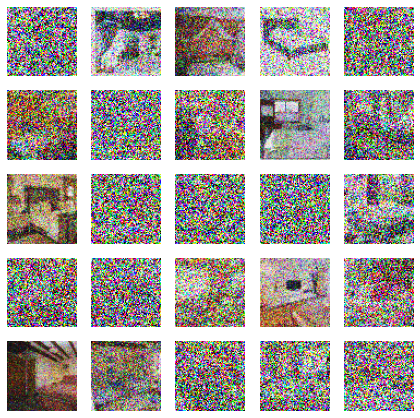

In [ ]:
show_images((xt[:25]*5).sigmoid(), imsize=1.5)

In [ ]:
lr = 3e-3
epochs = 25
opt_func = partial(optim.AdamW, eps=1e-5)
tmax = epochs * len(dls.train)
sched = partial(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=tmax)
cbs = [DeviceCB(), ProgressCB(plot=True), MetricsCB(), BatchSchedCB(sched), MixedPrecision()]
model = EmbUNetModel(in_channels=3, out_channels=3, nfs=(64,128,256,512), num_layers=2, attn_chans=0)
learn = Learner(model, dls, nn.MSELoss(), lr=lr, cbs=cbs, opt_func=opt_func)

loss,epoch,train
0.089,0,train
0.059,0,eval
0.046,1,train
0.044,1,eval
0.039,2,train
0.038,2,eval
0.035,3,train
0.035,3,eval
0.034,4,train
0.033,4,eval


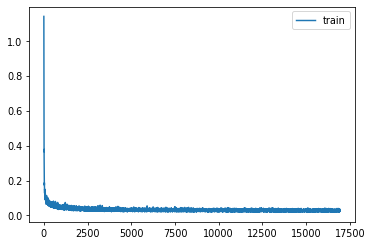

In [ ]:
learn.fit(epochs)

## Sampling

In [ ]:
sz = (64,3,64,64)

In [ ]:
# set_seed(42)
preds = sample(ddim_step, model, sz, steps=100, eta=1.)

In [ ]:
s = (preds[-1]+0.5)
s.min(),s.max(),s.shape

(tensor(-0.1057), tensor(1.1384), torch.Size([64, 3, 64, 64]))

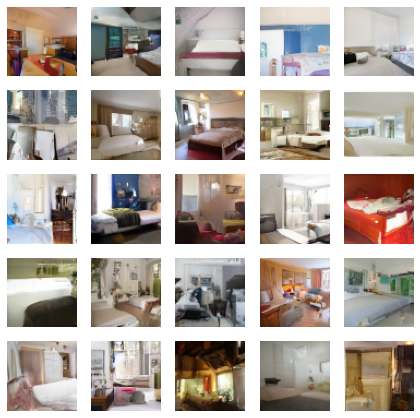

In [ ]:
show_images(s[:25].clamp(0,1), imsize=1.5)